# Model Development and Findings

In [199]:
#Imports
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import copy
import pfr
import time
from sklearn.grid_search import GridSearchCV

We first load our data into `completedf` and are careful to remove the 2002 year. This year was only included so that we can calculate our lag features such as `tm_prev_yr_pass` for the 2003 season

In [200]:
# reupload all data to have as one dataset again
completedf1 = pd.concat([pd.read_csv('0204plays.csv'),pd.read_csv('0507plays.csv'),pd.read_csv('0810plays.csv'),pd.read_csv('1114plays.csv')])

#(remove 2002, because it has served it's purpose of creating 2003 priors)
completedf = completedf1[completedf1['year']>2002].reset_index(drop=True)

# define number of plays in df, which is now our finalized dataset with all variables
plays = len(completedf)

In [201]:
print completedf.shape
completedf.head(2)

lcols = ["distToGoal","inDown3","inDown2","inDown1","inQuarter4","inQuarter3","inQuarter2","inQuarter1","secsElapsedInHalf","margin","yds_to_go","addscore","tm_TO_left","opp_TO_left","inFGRange", "inRedZone", "tm_winprob","inLast3minHalf", "tm_prev_yr_pass","tm_in_season_pass","tm_in_game_pass","StartofDrive","prevWasPass"]

(397349, 139)




We define our functions:
- `masking`: returns a mask for our DataFrame
- `cv_optimize`: returns a trained, best classifier (note: adopted from HW3)
- `do_classify`: returns a re-fitted, best classifier, training sets, test sets and test accuracy (note: adopted from HW3)

In [202]:
def masking(df,itrain,itest):    
    mask=np.ones(df.shape[0], dtype='int')
    mask[itrain]=1
    mask[itest]=0
    mask = (mask==1)
    return mask

In [203]:
def cv_optimize(clf, parameters, X, y, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

In [204]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.6f" % (training_accuracy)
    print "Accuracy on test data:     %0.6f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest, test_accuracy

We continue to define more functions to carry out the training of our classifiers
- runsvm2 for SVM
- runsvc2 for SVC
- randforest for Random Forest
- gradboost for Gradient Boost
- adaboost for our ADA Boost

In [257]:
#Function to run our linear SVM model with the hinge as our loss function
def runsvm2(df,lcols,mask,Cs):    
    from sklearn.svm import LinearSVC
    clfsvm_lin=LinearSVC(loss="hinge")
    parameters = {"C": Cs}
    # could add njobs to the mix to run them in parallel
    clfsvm_lin, Xtrainlin, ytrainlin, Xtestlin, ytestlin,_ = do_classify(clfsvm_lin, parameters, df, lcols, u'RESP', 1, mask=mask)
    return clfsvm_lin, Xtrainlin, ytrainlin, Xtestlin, ytestlin,_

#Function to run our SVC model
def runsvc2(df,lcols,mask,Cs):    
    from sklearn.svm import SVC
    clfsvm_orig = SVC()
    parameters = {"C": Cs}
    # could add njobs to the mix to run them in parallel
    clfsvm_orig, Xtrainorig, ytrainorig, Xtestorig, ytestorig,_ = do_classify(clfsvm_orig, parameters, df, lcols, u'RESP', 1, mask=mask)
    return clfsvm_orig, Xtrainorig, ytrainorig, Xtestorig, ytestorig,_

#Function to run our Random Forest classifiers
def randforest(df,lcols,mask):    
    from sklearn.ensemble import RandomForestClassifier
    clfForest = RandomForestClassifier()
    parameters = {"n_estimators": np.arange(1,100,5)}
    # could add njobs to the mix to run them in parallel
    clfForest, Xtrainrf, ytrainrf, Xtestrf, ytestrf,_ = do_classify(clfForest, parameters, df, lcols, u'RESP', 1, mask=mask, score_func='f1')
    return clfForest, Xtrainrf, ytrainrf, Xtestrf, ytestrf,_

#Function to run our Gradient Boost classifier
def gradboost(df,lcols,mask):
    from sklearn.ensemble import GradientBoostingClassifier
    clfGB = GradientBoostingClassifier()
    parameters = {"max_depth": range(1, 8)}
    clfGB, Xtraingb, ytraingb, Xtestgb, ytestgb,_ = do_classify(clfGB, parameters, df, lcols, u'RESP', 1, mask=mask, score_func='f1')
    return clfGB, Xtraingb, ytraingb, Xtestgb, ytestgb,_

#Function to run our ADA Boost classifier
def adaboost(clfForest,df,lcols,mask):
    from sklearn.ensemble import AdaBoostClassifier
    clfAda = AdaBoostClassifier(base_estimator=clfForest)
    parameters = {"n_estimators": np.arange(1, 100, 5)}
    clfAda, Xtrainada, ytrainada, Xtestada, ytestada,_ = do_classify(clfAda, parameters, df, lcols, u'RESP', 1, mask=mask, score_func='f1')
    return clfAda, Xtrainada, ytrainada, Xtestada, ytestada,_

These next few functions define two plots that we will use to analyze our classifiers. The `plot_features` function returns the relative importance of the top features used by the classifier whereas the `plot_decision_surface` and `plot_rf` functions (note: adopted from Lab 7) are used to display the decision surface for a variety of classifiers. 

In [258]:
#Plot function that returns the most important features in a classifier
def plot_features(clfForest,lcols,name):
    importance_list = clfForest.feature_importances_
    importance_list, name_list = zip(*sorted(zip(importance_list, lcols)))
    width = 0.8
    yTickPos = np.arange(len(importance_list))
    yBarPos = yTickPos - (width/2.0)
    plt.barh(yBarPos,importance_list,align='center', color="lightskyblue")
    plt.yticks(yTickPos, name_list)
    plt.ylim((min(yTickPos)-0.6, max(yTickPos)+0.6))
    plt.grid(False)
    plt.xlabel('Relative Importance')
    plt.ylabel('Features')
    plt.title('Relative Importance of Each Feature for %s' % str(name))
    plt.show()
    
#Plots the decision surface
def plot_decision_surface(clf, X_train, Y_train):
    plot_step=0.1
    
    if X_train.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = X_train[:, 0].min() - plot_step, X_train[:, 0].max() + plot_step
    y_min, y_max = X_train[:, 1].min() - plot_step, X_train[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))

    clf.fit(X_train,Y_train)
    if hasattr(clf, 'predict_proba'):
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])    
    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Reds)
    plt.scatter(X_train[:,0],X_train[:,1],c=Y_train,cmap=plt.cm.Paired, alpha=0.40, s=20)
    plt.show()
    
    print type(X_train[:, 0].min()), type(plot_step)
    
# Function that prepares the decision surface plot for a given classifier
def plot_rf(clfForest,label,lcols,df):
    xt = [lcols[e] for e in clfForest.feature_importances_.argsort()[::-1][0:2]]
    X_imp = df[xt].values
    Y = df.RESP.values
    plt.title(label)
    plt.xlabel(xt[0])
    plt.ylabel(xt[1])
    plt.grid(False)
    plot_decision_surface(clfForest, X_imp, Y)

### Running our classifiers


Due to the large nature of our dataset (around half a million samples), we elected to run our classifiers on only a subset of the DataFrame. We choose the `2014` year to perform the analysis though we very well could have chosen any year. Before using our predefined functions to run our classifiers, it's necessary to create our `mask` and `Cs` parameter.

In [253]:
#Obtain subset of data frame
year = 2014 # whatever year you want to test
df = completedf[completedf['year']==year]

In [208]:
#Create mask for our dataframe
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(df.shape[0]), train_size=0.7)
mask = masking(df,itrain,itest)
Cs=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0] # try fewer if doesn't finish up

**Run our SVM classifier:**

In [209]:
# run linear svm model
clfsvm_lin, Xtrainlin, ytrainlin, Xtestlin, ytestlin,_ = runsvm2(df, lcols, mask, Cs)

using mask
BEST {'C': 0.001} 0.628292394199 [mean: 0.62829, std: 0.01645, params: {'C': 0.001}, mean: 0.61320, std: 0.04503, params: {'C': 0.01}, mean: 0.61582, std: 0.01367, params: {'C': 0.1}, mean: 0.57798, std: 0.05633, params: {'C': 1.0}, mean: 0.57561, std: 0.05616, params: {'C': 10.0}, mean: 0.57671, std: 0.07231, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.601911
Accuracy on test data:     0.601953
[[ 113 3978]
 [  57 5989]]
########################################################


/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Our SVM classifier performs decent as it has 60.2% accuracy on the test set. It's also evident from the confusion matrix that this classifier grossly overpredicts pass as it wrongly predicted 3,978 runs as passes. 


**Run our SVC classifier:**

In [210]:
# run svc model
clfsvm_orig, Xtrainorig, ytrainorig, Xtestorig, ytestorig,_ = runsvc2(df, lcols, mask, Cs)

using mask
BEST {'C': 1.0} 0.597133555997 [mean: 0.59701, std: 0.00005, params: {'C': 0.001}, mean: 0.59701, std: 0.00005, params: {'C': 0.01}, mean: 0.59701, std: 0.00005, params: {'C': 0.1}, mean: 0.59713, std: 0.00177, params: {'C': 1.0}, mean: 0.59506, std: 0.00368, params: {'C': 10.0}, mean: 0.59519, std: 0.00367, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.995603
Accuracy on test data:     0.592187
[[ 136 3955]
 [ 179 5867]]
########################################################


/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Our SVC classifier does not perform as well as our SVM classifier. The SVC only has 59.2% accuracy on the test set and  severely overpredicts pass as it wrongly predicted 3,955 runs as passes. It's clear that this classifier and the SVM have a bias towards predicting pass plays


**Run our Logistic Regression with lasso classifier:**

In [211]:
# run logistic regression with lasso model
from sklearn.linear_model import LogisticRegression
clflog, Xtrain1, ytrain1, Xtest1, ytest1,_ = do_classify(LogisticRegression(penalty="l1"), {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, df, lcols, u'RESP', 1, mask=mask)

using mask
BEST {'C': 10} 0.668456432588 [mean: 0.59798, std: 0.01162, params: {'C': 0.001}, mean: 0.65818, std: 0.01219, params: {'C': 0.01}, mean: 0.66765, std: 0.01119, params: {'C': 0.1}, mean: 0.66812, std: 0.00949, params: {'C': 1}, mean: 0.66846, std: 0.00935, params: {'C': 10}, mean: 0.66765, std: 0.00968, params: {'C': 100}]
############# based on standard predict ################
Accuracy on training data: 0.669175
Accuracy on test data:     0.670218
[[2073 2018]
 [1325 4721]]
########################################################


/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Our Logistic Regression with lasso performs much better than our previous two classifiers as its accuracy on the test set is 67.0% and it has less of a bias towards predicting passes. This classifier only predicts 2018 false positives.


**Run our Logistic Ridge Regression classifier:**

In [212]:
# run logistic model 2
clflog2, Xtrain2, ytrain2, Xtest2, ytest2,_ = do_classify(LogisticRegression(penalty="l2"), {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, df, lcols, u'RESP', 1, mask=mask)

using mask
BEST {'C': 10} 0.668456432588 [mean: 0.64998, std: 0.00823, params: {'C': 0.001}, mean: 0.66440, std: 0.01108, params: {'C': 0.01}, mean: 0.66761, std: 0.00969, params: {'C': 0.1}, mean: 0.66833, std: 0.00946, params: {'C': 1}, mean: 0.66846, std: 0.00851, params: {'C': 10}, mean: 0.66799, std: 0.00954, params: {'C': 100}]
############# based on standard predict ################
Accuracy on training data: 0.668710
Accuracy on test data:     0.670119
[[2080 2011]
 [1333 4713]]
########################################################


/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


The Logistic Regression with ridge performs nearly identical to our previous logistic regression. The ridge regression has a test set accuracy of 67.0% as well and similarly predicts 2011 false positives (runs that were predicted as a pass).  


**Run our Random Forest classifier:**

In [213]:
#Random forest classifier
clfForest, Xtrainrf, ytrainrf, Xtestrf, ytestrf,_ = randforest(df,lcols,mask)

using mask
BEST {'n_estimators': 81} 0.746282979636 [mean: 0.67632, std: 0.00282, params: {'n_estimators': 1}, mean: 0.68421, std: 0.00635, params: {'n_estimators': 6}, mean: 0.72702, std: 0.00391, params: {'n_estimators': 11}, mean: 0.71918, std: 0.00499, params: {'n_estimators': 16}, mean: 0.73546, std: 0.00878, params: {'n_estimators': 21}, mean: 0.73265, std: 0.00572, params: {'n_estimators': 26}, mean: 0.74058, std: 0.00591, params: {'n_estimators': 31}, mean: 0.73353, std: 0.00553, params: {'n_estimators': 36}, mean: 0.74192, std: 0.00670, params: {'n_estimators': 41}, mean: 0.73903, std: 0.00768, params: {'n_estimators': 46}, mean: 0.74400, std: 0.00700, params: {'n_estimators': 51}, mean: 0.73999, std: 0.00181, params: {'n_estimators': 56}, mean: 0.74495, std: 0.00606, params: {'n_estimators': 61}, mean: 0.74365, std: 0.00438, params: {'n_estimators': 66}, mean: 0.74476, std: 0.00561, params: {'n_estimators': 71}, mean: 0.74177, std: 0.00389, params: {'n_estimators': 76}, mean:

/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Finally some improvement! Our Random Forest classifier yields a 69.3% accuracy on our test set and only predicts 1696 false positives. From the confusion matrix, it seems that it has a much lower bias towards predicting passes but in return predicts more false negatives (passes that were predicted as runs) than the previous classifiers. 

We now display a plot of the most important features of our Random Forest Classifier:

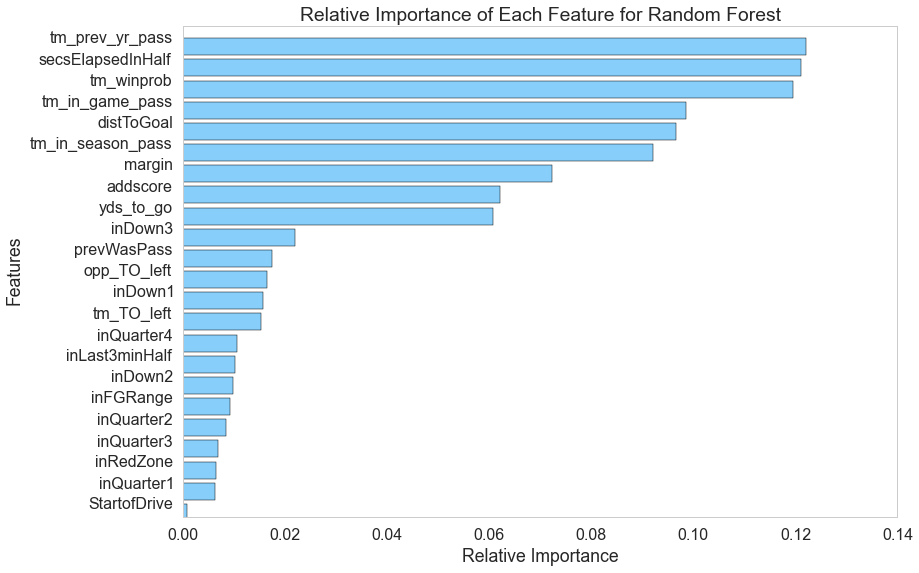

In [214]:
# make random forest plots
plot_features(clfForest,lcols,"Random Forest")

Here, it's evident that `tm_prev_yr_pass` and `secsElapsedInHalf` are the most important features, however, it's also interesting to note that every feature until `yds_to_go` seems to be relevant as well. 


Next we display the decision surface of our Random Forest:

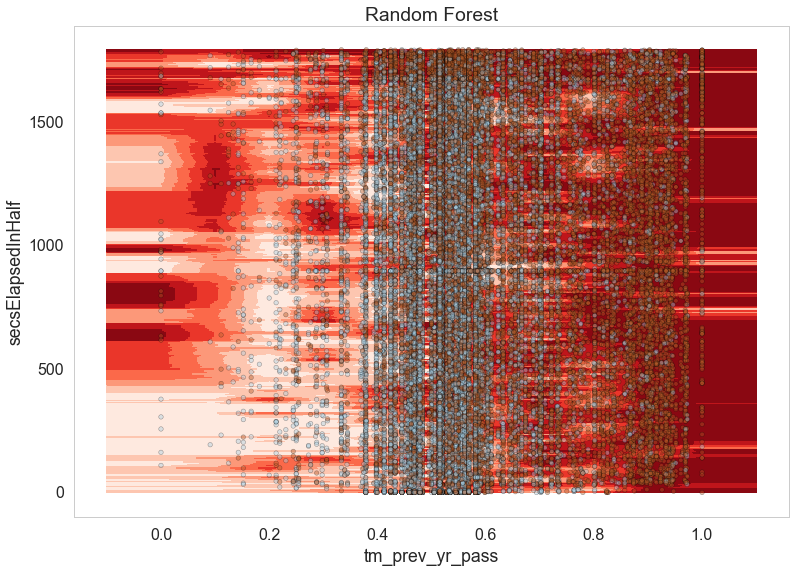

<type 'numpy.float64'> <type 'float'>


In [215]:
# make random forest plots
plot_rf(clfForest,"Random Forest",lcols,df)

The increased accuracy of the Random Forest classifier is displayed in the above decision surface plot. The red and blue data points represent passes and runs respectively, and with a perfect classifier, the white underlay would completely surround the blue points whereas the red underlay would encompass the red. The more accurate a classifier is, the more apparent this effect is. Thus, it seems that the Random Forest classifier is fairly reliable as the red of its decision surface surrounds the red points near the 1.0 value on the `tm_prev_yr_pass` (previous year pass percentage) axis, and the white points are accompanied by a mainly white decision surface. 


**Run our ADA Boost classifier:**

In [262]:
# ADA Boost Classifier
from sklearn.ensemble import RandomForestClassifier
clfAda, Xtrainada, ytrainada, Xtestada, ytestada,_ = adaboost(RandomForestClassifier(n_estimators=33),df,lcols,mask) 

using mask
BEST {'n_estimators': 26} 0.75144948496 [mean: 0.74161, std: 0.00657, params: {'n_estimators': 1}, mean: 0.74929, std: 0.00508, params: {'n_estimators': 6}, mean: 0.75098, std: 0.00499, params: {'n_estimators': 11}, mean: 0.74948, std: 0.00663, params: {'n_estimators': 16}, mean: 0.75131, std: 0.00636, params: {'n_estimators': 21}, mean: 0.75145, std: 0.00462, params: {'n_estimators': 26}, mean: 0.74919, std: 0.00564, params: {'n_estimators': 31}, mean: 0.74843, std: 0.00576, params: {'n_estimators': 36}, mean: 0.74965, std: 0.00552, params: {'n_estimators': 41}, mean: 0.75086, std: 0.00502, params: {'n_estimators': 46}, mean: 0.75079, std: 0.00609, params: {'n_estimators': 51}, mean: 0.74836, std: 0.00553, params: {'n_estimators': 56}, mean: 0.74946, std: 0.00481, params: {'n_estimators': 61}, mean: 0.74846, std: 0.00445, params: {'n_estimators': 66}, mean: 0.74829, std: 0.00626, params: {'n_estimators': 71}, mean: 0.74953, std: 0.00471, params: {'n_estimators': 76}, mean: 

/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Our ADA Boost classifier performed similarly to our Random Forest classifier as the ADA reports an accuracy of 69.8% and similar false positive and false negative counts in the confusion matrix. 


We then proceeded to plot the important features of our ADA classifier:

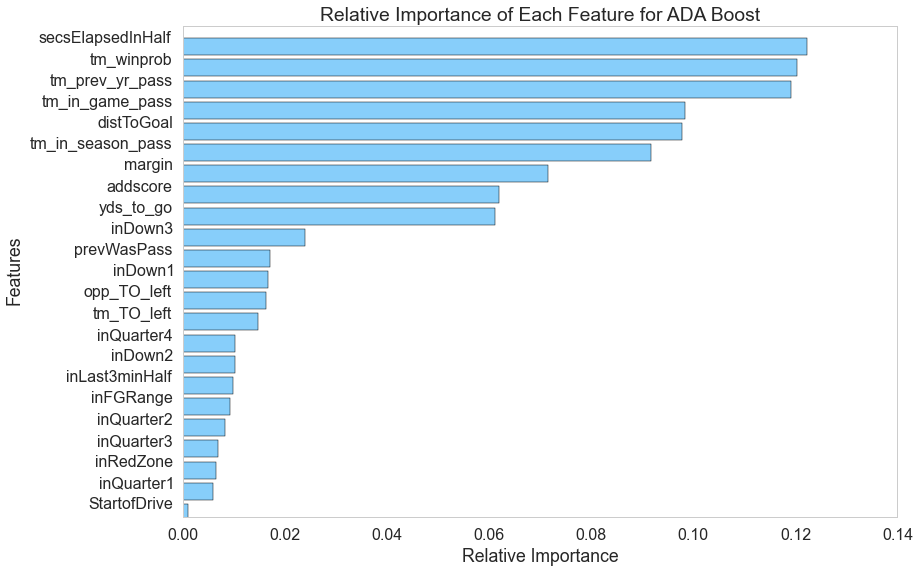

In [217]:
# make ada boost features plots
plot_features(clfAda,lcols,"ADA Boost")

This features plot is interesting because the ADA gives different relative weights than the Random Forest classifier. The ADA considers `secsElapsedInHalf` and `tm_winprob` the first and second most important features respectively whereas the Random Forest shows that `tm_prev_yr_pass` and `secsElapsedInHalf` are the first and second most valeud inputs respectively. It's also worth noting that the top 3 most important features are the same for both classifiers and this disparity amongst them is minimal. 


Now we proceed to make a decision surface plot of the ADA classifier:

In [ ]:
# make ada boost plots
plot_rf(clfAda,"Ada Boost",lcols,df)

# COMMENT ON THE DECISION SURFACE


**Run our Gradient Boost classifier:**

In [254]:
# Gradient Boost CLassifier
clfGB, Xtraingb, ytraingb, Xtestgb, ytestgb,_ = gradboost(df,lcols,mask)

using mask
BEST {'max_depth': 3} 0.748515880401 [mean: 0.74427, std: 0.00367, params: {'max_depth': 1}, mean: 0.74694, std: 0.00461, params: {'max_depth': 2}, mean: 0.74852, std: 0.00249, params: {'max_depth': 3}, mean: 0.74709, std: 0.00628, params: {'max_depth': 4}, mean: 0.74577, std: 0.00509, params: {'max_depth': 5}, mean: 0.74513, std: 0.00761, params: {'max_depth': 6}, mean: 0.74342, std: 0.01055, params: {'max_depth': 7}]
############# based on standard predict ################
Accuracy on training data: 0.709889
Accuracy on test data:     0.706422
[[2554 1537]
 [1439 4607]]
########################################################
(23653, 23)
(10137, 23)


/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


The performance of our Gradient Boost classifier is our best yet. This ensemble classifier predicts a run vs. pass plays on our test set with an accuracy of 70.6%. This accuracy is highlighted in the reduced false positives and relatively constant false negative counts in the confusion matrix compared to the those from the ADA confusion matrix. 


We continue to explore the Gradient Boost classifier by analyzing its most relevant features:

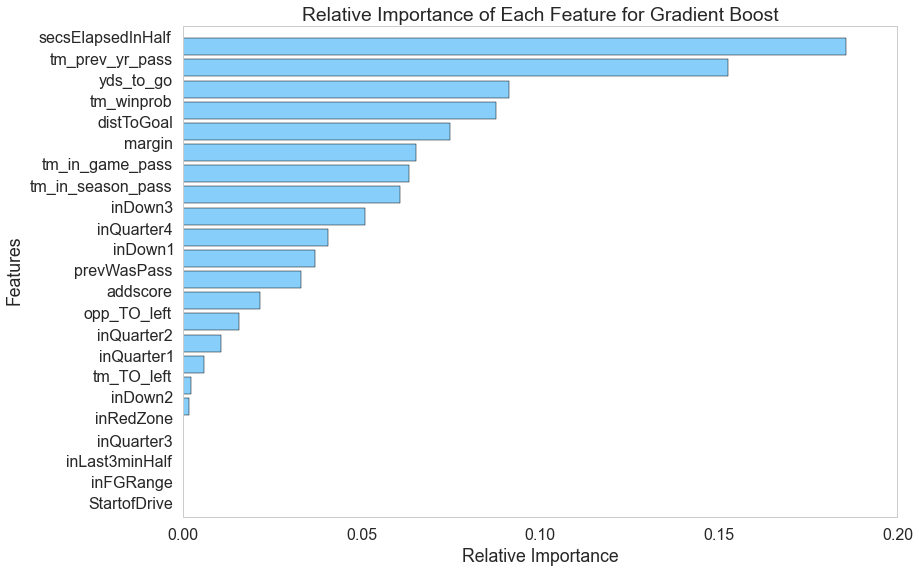

In [235]:
# make gradient boost features plots
plot_features(clfGB,lcols,"Gradient Boost")

The Gradient Booster classifier gives highest weight to the `secsElapsedInHalf` and `tm_prev_yr_pass` features respectively and uniquely considers the `yds_to_go` variable as its third most important feature. The discrepancy of relative importance among its top three candidates is much larger than that of the ADA classifier or the Random Forest classifier. This suggests that the more accurate result is due to the higher stress the Gradient Booster allocates to the `secsElapsedInHalf` and possibly the `tm_prev_yr_pass` features.


The decision surface plot for the Gradient Boost classifier:

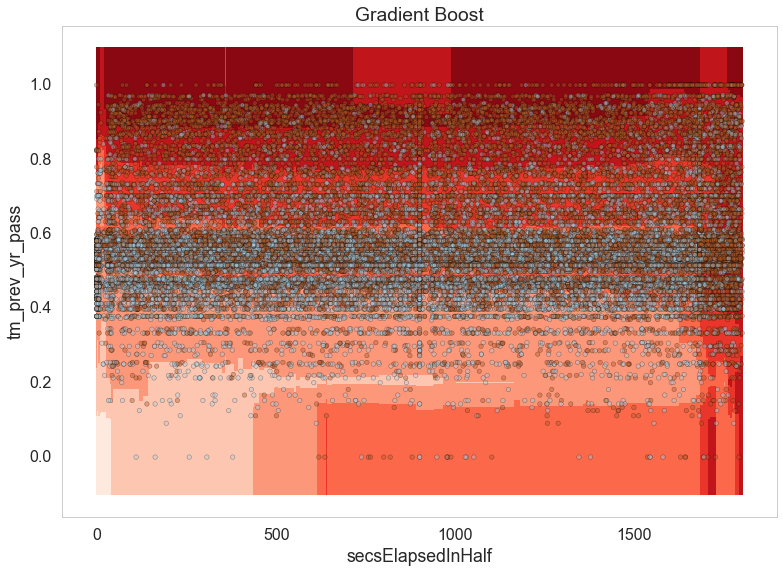

<type 'numpy.float64'> <type 'float'>


In [236]:
# make gradient boost plots
plot_rf(clfGB,"Gradient Boost",lcols,df)

The decision surface looks more uniform than that of the Random Forest as there is more continuity in the transitions of the classifiers predictions. (Note: the axis are switched when compared to the Random Forest plot since the Gradient Boost weighs `secsElapsedInHalf` over `tm_prev_yr_pass` whereas the Random Forest considers the latter more so than the former). The high accuracy of the Gradient Boost is displayed by the dark red of the decision surface surrounding the red points and the whiter areas engulfing the lighter points. 


### ROC Curve Comparison 


Define the `make_roc` function (adopted from HW3):

In [259]:
# Define the make_roc function to plot the classifiers accuracies
from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        preds = clf.predict_proba(xtest)[:,1]
        fpr, tpr, thresholds=roc_curve(ytest, preds)
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
        ax.grid(False)
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
    ax.legend(loc="lower right")
    return ax

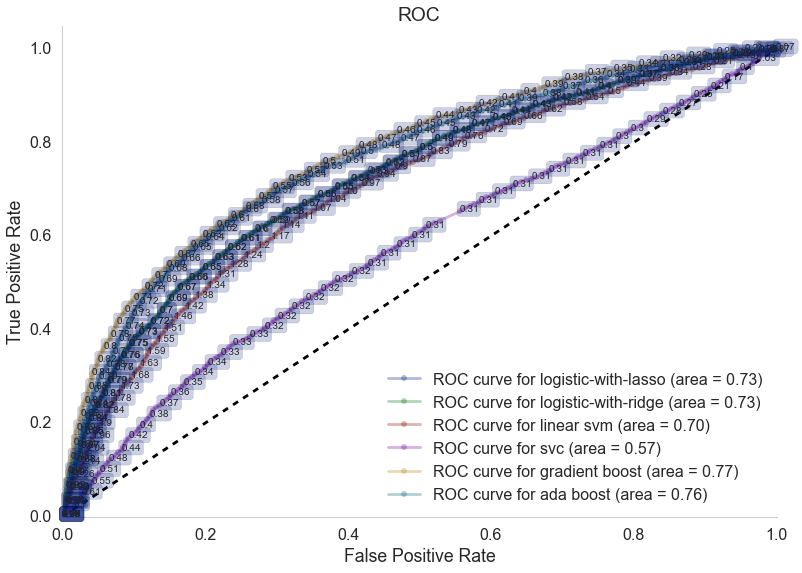

In [264]:
# Plot the classifiers accuracies
with sns.color_palette("dark"):
    ax=make_roc("logistic-with-lasso",clflog, ytest1, Xtest1, labe=200, proba=True, skip=50)
    make_roc("logistic-with-ridge",clflog2, ytest2, Xtest2, ax, labe=200, proba=True, skip=50);
    make_roc("linear svm",clfsvm_lin, ytestlin, Xtestlin, ax, labe=200, proba=False, skip=50);
    make_roc("svc",clfsvm_orig, ytestorig, Xtestorig, ax, labe=200, proba=False, skip=50);
    make_roc("gradient boost",clfGB, ytestgb, Xtestgb, ax, labe=200, proba=True, skip=50);
    make_roc("ada boost",clfAda, ytestada, Xtestada, ax, labe=200, proba=True, skip=50);

This ROC curve is fascinating because it visualizes the results of our prior discussion on the performance of our classifiers. In this graph, the best performing classifier has the most area under the curve and typically is displayed as having the most top-left bulge. This visualization thus supports the Gradient Boost classifier as our most accurate since it posesses an area of 0.77 and seems to engulf the other curves in that its the outer most curve. This plot also displays the poor performance of the SVC as our previous analysis suggested. 


### Display the performance of these classifiers over the 2003-2014 seasons:


The below code calculates the test accuracy of the svm, logistic with lasso, logistic with ridge, random forest and gradient boost classifiers for each year between `2003` and `2014` (inclusive). 

In [265]:
# Compile progression of quick classifier's performance
years = np.arange(2003,2015)
svm_ = []
log_lasso = []
log_ridge = []
rf = []
gb = []
for yr in years:
    dfp = completedf[completedf['year']==year]
    _, _, _, _, _,svm_acc = runsvm2(dfp, lcols, mask, Cs)
    _, _, _, _, _,log_lasso_acc = do_classify(LogisticRegression(penalty="l1"), {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, df, lcols, u'RESP', 1, mask=mask)
    _, _, _, _, _,log_ridge_acc = do_classify(LogisticRegression(penalty="l2"), {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, df, lcols, u'RESP', 1, mask=mask)
    _, _, _, _, _,rf_acc = randforest(df,lcols,mask)
    _, _, _, _, _,gb_acc = gradboost(df,lcols,mask)
    svm_.append(svm_acc)
    log_lasso.append(log_lasso_acc)
    log_ridge.append(log_ridge)
    rf.append(rf_acc)
    gb.append(gb_acc)
performance = [svm_,log_lasso,log_ridge,rf,gb]

using mask
BEST {'C': 100.0} 0.590284530504 [mean: 0.58077, std: 0.04416, params: {'C': 0.001}, mean: 0.56306, std: 0.05679, params: {'C': 0.01}, mean: 0.57024, std: 0.07273, params: {'C': 0.1}, mean: 0.52759, std: 0.08777, params: {'C': 1.0}, mean: 0.56027, std: 0.07578, params: {'C': 10.0}, mean: 0.59028, std: 0.04393, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.608675
Accuracy on test data:     0.608957
[[ 312 3779]
 [ 185 5861]]
########################################################
using mask
BEST {'C': 0.1} 0.66773770769 [mean: 0.59785, std: 0.01166, params: {'C': 0.001}, mean: 0.65818, std: 0.01221, params: {'C': 0.01}, mean: 0.66774, std: 0.01113, params: {'C': 0.1}, mean: 0.66736, std: 0.00911, params: {'C': 1}, mean: 0.66765, std: 0.00933, params: {'C': 10}, mean: 0.66774, std: 0.00982, params: {'C': 100}]
############# based on standard predict ################
Accuracy on training data: 0.669640
Accuracy on t

/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


We now visualize these results:

In [ ]:
# Display progression
N = len(performance)
labels = ["svm", "logistic-lasso", "logistic-ridge", "random forest", "gradient boost"]
for i in range(N):
    plt.plot(years, performance[i], label = labels[i], lw=1, ls = "-")
plt.grid(False)
plt.xlabel("Years")
plt.ylabel("Classifier accuracy on test set")
plt.title("Progression of Classifier Accuracy")
sns.despine()
plt.legend(loc="best")

In [ ]:
performance

[Proceed Back to Index Notebook Please]()